In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from tqdm import tqdm

import torch.nn as nn            # containing various building blocks for your neural networks
import torch.optim as optim      # implementing various optimization algorithms
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
# transforms: transformations useful for image processing
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from dataset import BengaliDatasetTrain

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def show_imgs(dataset, nrow=5, ncol=5, figsize=(20, 8)):
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        image = dataset[i]['image'].numpy().astype(np.uint8).transpose(1, 2, 0)
        ax.imshow(image, cmap='Greys')
    plt.tight_layout()
    plt.show()

In [36]:
dataset = BengaliDatasetTrain([1, 2])

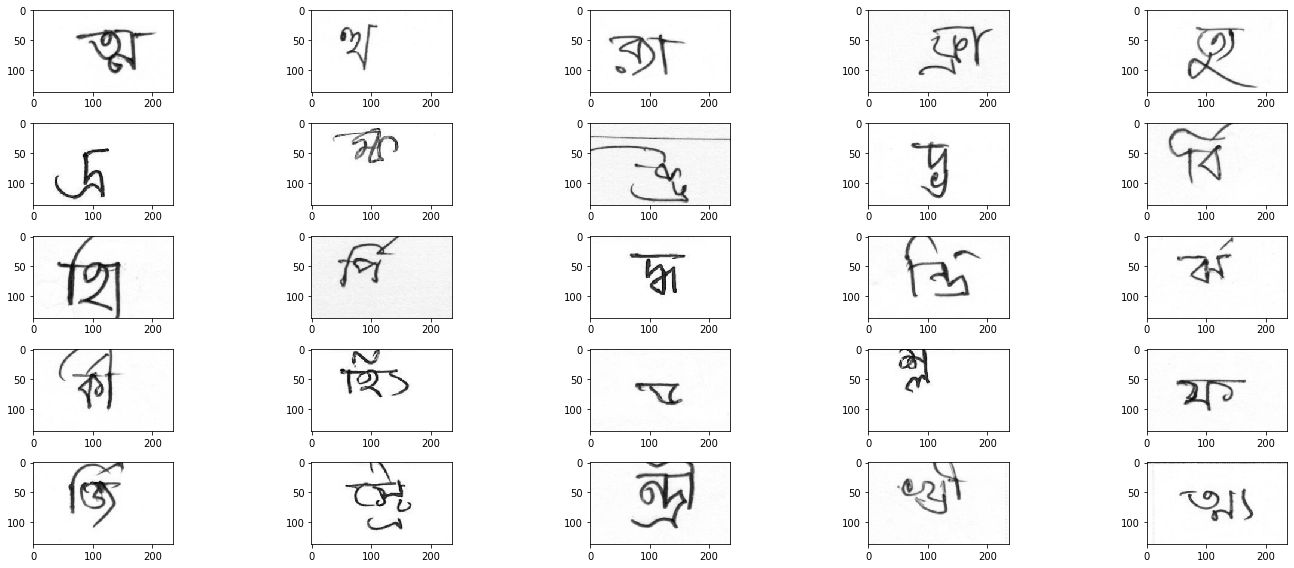

In [37]:
show_imgs(dataset)